### https://arxiv.org/pdf/2402.08593

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, RocCurveDisplay

from sklearn.preprocessing import normalize

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd
import xgboost as xgb

import settings as s

assert s.FILE_SIZE == "Small"
assert s.HIGH_ILLICIT == True

os.environ["EXT_DATA_TYPE_FOLDER"] = s.OUTPUT_POSTFIX.lstrip("-")

from common import get_weights, delete_large_vars, MULTI_PROC_STAGING_LOCATION
from communities import get_communities_spark
from features import (
    generate_features_spark, generate_features_udf_wrapper, get_edge_features_udf,
    SCHEMA_FEAT_UDF, CURRENCY_RATES
)

%load_ext autoreload
%autoreload 2

In [2]:
start_script = time.time()

In [3]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [4]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/30 12:33:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
TRAIN_PERC = 0.6
VALIDATION_PERC = 0.2
TEST_PERC = 0.2

KEEP_TOP_N = 100

assert(sum([TRAIN_PERC, VALIDATION_PERC, TEST_PERC]) == 1)

location_main = os.path.join("features", os.environ["EXT_DATA_TYPE_FOLDER"])
# shutil.rmtree(location_main, ignore_errors=True)

location_communities_leiden = f"{location_main}{os.sep}communities_leiden.parquet"

location_features_leiden = f"{location_main}{os.sep}features_leiden.parquet"
location_features_ego = f"{location_main}{os.sep}features_ego.parquet"
location_features_2_hop = f"{location_main}{os.sep}features_2_hop.parquet"
location_features_2_hop_out = f"{location_main}{os.sep}features_2_hop_out.parquet"
location_features_2_hop_in = f"{location_main}{os.sep}features_2_hop_in.parquet"
location_features_2_hop_combined = f"{location_main}{os.sep}features_2_hop_combined.parquet"
location_features_source = f"{location_main}{os.sep}features_source.parquet"
location_features_target = f"{location_main}{os.sep}features_target.parquet"

location_flow_dispense = f"{location_main}{os.sep}location_flow_dispense.parquet"
location_flow_passthrough = f"{location_main}{os.sep}location_flow_passthrough.parquet"
location_flow_sink = f"{location_main}{os.sep}location_flow_sink.parquet"

location_comm_as_source_features = f"{location_main}{os.sep}comm_as_source_features.parquet"
location_comm_as_target_features = f"{location_main}{os.sep}comm_as_target_features.parquet"
location_comm_as_passthrough_features = f"{location_main}{os.sep}comm_as_passthrough_features.parquet"
location_comm_as_passthrough_features_reverse = f"{location_main}{os.sep}comm_as_passthrough_features_reverse.parquet"

location_features_node_level = f"{location_main}{os.sep}features_node_level.parquet"
location_features_edges = f"{location_main}{os.sep}features_edges.parquet"

location_features_edges_train = f"{location_main}{os.sep}features_edges_train.parquet"
location_features_edges_valid = f"{location_main}{os.sep}features_edges_valid.parquet"
location_features_edges_test = f"{location_main}{os.sep}features_edges_test.parquet"

location_train_trx_features = f"{location_main}{os.sep}train_trx_features.parquet"
location_valid_trx_features = f"{location_main}{os.sep}valid_trx_features.parquet"
location_test_trx_features = f"{location_main}{os.sep}test_trx_features.parquet"

location_train_features = f"{location_main}{os.sep}train_features.parquet"
location_valid_features = f"{location_main}{os.sep}valid_features.parquet"
location_test_features = f"{location_main}{os.sep}test_features.parquet"

try:
    os.makedirs(location_main)
except FileExistsError:
    pass

In [6]:
data = spark.read.parquet(s.STAGED_DATA_LOCATION)
data = data.withColumn("is_laundering", sf.col("is_laundering").cast("boolean"))
data_count_original = data.count()

In [7]:
%%time

trx_ids_sorted = data.sort("timestamp").select("transaction_id").toPandas()["transaction_id"].values
trx_count = len(trx_ids_sorted)

last_train_index = int(np.floor(trx_count * TRAIN_PERC))
last_validation_index = last_train_index + int(np.floor(trx_count * VALIDATION_PERC))
train_indexes = trx_ids_sorted[:last_train_index]
validation_indexes = trx_ids_sorted[last_train_index:last_validation_index]
test_indexes = trx_ids_sorted[last_validation_index:]

train_indexes = spark.createDataFrame(
    pd.DataFrame(train_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)
validation_indexes = spark.createDataFrame(
    pd.DataFrame(validation_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)
test_indexes = spark.createDataFrame(
    pd.DataFrame(test_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)

train = train_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
validation = validation_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
test = test_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
train_count, validation_count, test_count = train.count(), validation.count(), test.count()
print()
print(trx_count, train_count, validation_count, test_count)
print()

25/07/26 17:25:06 WARN TaskSetManager: Stage 8 contains a task of very large size (8183 KiB). The maximum recommended task size is 1000 KiB.
25/07/26 17:25:07 WARN TaskSetManager: Stage 10 contains a task of very large size (8183 KiB). The maximum recommended task size is 1000 KiB.
25/07/26 17:25:12 WARN TaskSetManager: Stage 21 contains a task of very large size (2734 KiB). The maximum recommended task size is 1000 KiB.
25/07/26 17:25:12 WARN TaskSetManager: Stage 23 contains a task of very large size (2734 KiB). The maximum recommended task size is 1000 KiB.
25/07/26 17:25:15 WARN TaskSetManager: Stage 34 contains a task of very large size (2734 KiB). The maximum recommended task size is 1000 KiB.
25/07/26 17:25:15 WARN TaskSetManager: Stage 36 contains a task of very large size (2734 KiB). The maximum recommended task size is 1000 KiB.
[Stage 39:================================================>    (184 + 12) / 200]


5072693 3043615 1014538 1014540

CPU times: user 64.9 ms, sys: 42.4 ms, total: 107 ms
Wall time: 16.9 s


In [8]:
%%time

edges = data.groupby(["source", "target"]).agg(
    sf.sum("amount").alias("amount")
).toPandas()
weights = get_weights(edges)
edges_agg = edges.set_index(["source", "target"]).join(
    weights.set_index(["source", "target"]), how="left"
).reset_index()
edges_agg.loc[:, "amount_weighted"] = (
    edges_agg.loc[:, "amount"] * 
    (edges_agg.loc[:, "weight"] / edges_agg.loc[:, "weight"].max())
)

CPU times: user 5.99 s, sys: 148 ms, total: 6.14 s
Wall time: 9.05 s


In [9]:
# Later on, we will reset the variables (to free up memory), while still keeping these intact
to_keep = %who_ls
to_keep = list(to_keep)

In [10]:
%%time

TOP_N = 50
NUM_HOPS = 5

data_input = spark.createDataFrame(edges_agg)
nodes_source = set(edges_agg["source"].unique())
nodes_target = set(edges_agg["target"].unique())
nodes_passthrough = nodes_source.intersection(nodes_target)

%run generate_flow_features.ipynb

comm_as_source_features.to_parquet(location_comm_as_source_features)
comm_as_target_features.to_parquet(location_comm_as_target_features)
comm_as_passthrough_features.to_parquet(location_comm_as_passthrough_features)
comm_as_passthrough_features_reverse.to_parquet(location_comm_as_passthrough_features_reverse)

del comm_as_source_features
del comm_as_target_features
del comm_as_passthrough_features
del comm_as_passthrough_features_reverse

25/07/26 17:25:29 WARN TaskSetManager: Stage 50 contains a task of very large size (5378 KiB). The maximum recommended task size is 1000 KiB.



Processing comm_as_source

Processed hop #1 | 609,479 | 304,896
Processed hop #2 | 878,611 | 182,007
Processed hop #3 | 1,204,789 | 136,313
Processed hop #4 | 1,484,369 | 117,205
Processed hop #5 | 1,709,156 | 105,894

Processing comm_as_target

Processed hop #1 | 642,727 | 283,656
Processed hop #2 | 2,584,739 | 228,416
Processed hop #3 | 3,335,348 | 204,751
Processed hop #4 | 4,138,358 | 190,495
Processed hop #5 | 4,690,342 | 180,932

Processing comm_as_passthrough

Processed hop #1 | 504,165 | 211,409
Processed hop #2 | 718,202 | 132,477
Processed hop #3 | 994,799 | 106,327
Processed hop #4 | 1,214,780 | 91,457
Processed hop #5 | 1,381,540 | 82,404

Processing comm_as_passthrough_reverse

Processed hop #1 | 603,456 | 266,303
Processed hop #2 | 2,430,787 | 214,752
Processed hop #3 | 3,139,228 | 192,636
Processed hop #4 | 3,895,105 | 179,451
Processed hop #5 | 4,420,789 | 170,644


comm_as_source_features

CPU times: user 28.4 s, sys: 161 ms, total: 28.5 s
Wall time: 28.5 s

comm_as_t

In [11]:
%%time

print("Constructing Leiden communities")

graph = ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_weighted"]], use_vids=False, directed=True)
nodes_mapping = {x.index: x["name"] for x in graph.vs()}
communities_leiden = la.find_partition(
    graph, la.ModularityVertexPartition, n_iterations=100, weights="amount_weighted"
)
communities_leiden = [[nodes_mapping[_] for _ in x] for x in communities_leiden]
communities_leiden = [(str(uuid.uuid4()), set(x)) for x in communities_leiden]
sizes_leiden = [len(x[1]) for x in communities_leiden]

with open(location_communities_leiden, "wb") as fl:
    pickle.dump(communities_leiden, fl)

Constructing Leiden communities
CPU times: user 10min 54s, sys: 8.03 s, total: 11min 2s
Wall time: 11min 1s


In [12]:
# with open(location_communities_leiden, "rb") as fl:
#     communities_leiden = pickle.load(fl)

In [13]:
%%time

data_agg_weights = get_weights(
    data.groupby(["source", "target"])
    .agg(
        sf.sum("amount").alias("amount")
    ).toPandas()
)

data_agg_weights_rev = data_agg_weights.rename(
    columns={"target": "source", "source": "target"}
).loc[:, ["source", "target", "weight"]]
data_agg_weights_ud = pd.concat([data_agg_weights, data_agg_weights_rev], ignore_index=True)
data_agg_weights_ud = data_agg_weights_ud.groupby(["source", "target"]).agg(weight=("weight", "sum")).reset_index()

data_agg_weights_ud.sort_values("weight", ascending=False, inplace=True)
grouped_ud = data_agg_weights_ud.groupby("source").head(KEEP_TOP_N).reset_index(drop=True)
grouped_ud = grouped_ud.groupby("source").agg(targets=("target", set))

total = grouped_ud.index.nunique()
nodes_neighborhoods = {}
for index, (source, targets) in enumerate(grouped_ud.iterrows()):
    community_candidates = {source}
    for target in targets["targets"]:
        community_candidates |= (grouped_ud.loc[target, "targets"] | {target})
    nodes_neighborhoods[source] = set(community_candidates)
    if not (index % 250_000):
        print(index, total)

del data_agg_weights_rev
del data_agg_weights_ud
del grouped_ud

0 513439
250000 513439
500000 513439
CPU times: user 21.1 s, sys: 267 ms, total: 21.4 s
Wall time: 23 s


In [14]:
%%time

print("Constructing 2-hop communities")

communities_2_hop = get_communities_spark(
    nodes_neighborhoods,
    ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_weighted"]], use_vids=False, directed=True), 
    os.cpu_count(), spark, 2, "all", 0.01, "amount_weighted"
)
sizes_2_hop = [len(x[1]) for x in communities_2_hop]

Constructing 2-hop communities


CPU times: user 4.66 s, sys: 182 ms, total: 4.84 s
Wall time: 25.9 s


In [15]:
%%time

ts_min = data.select(sf.min("timestamp").alias("x")).collect()[0]["x"] - timedelta(minutes=1)
data_graph_agg = data.groupby(["source", "target", "source_bank", "target_bank", "source_currency"]).agg(
    sf.count("source").alias("num_transactions"),
    sf.sum("amount").alias("amount"),
    sf.sum("source_amount").alias("source_amount"),
    sf.collect_list(sf.array((sf.col("timestamp") - ts_min).cast("long"), sf.col("amount"))).alias("timestamps_amounts"),
)
data_graph_agg_sdf = data_graph_agg.persist(StorageLevel.DISK_ONLY)
print(data_graph_agg_sdf.count())
data_graph_agg = data_graph_agg_sdf.toPandas()
index = ["source", "target"]
edges_agg.loc[:, index + ["weight"]].set_index(index)
data_graph_agg = data_graph_agg.set_index(index).join(
    edges_agg.loc[:, index + ["weight"]].set_index(index), how="left"
).reset_index()
data_graph_agg.loc[:, "amount_weighted"] = (
    data_graph_agg.loc[:, "amount"] * 
    (data_graph_agg.loc[:, "weight"] / data_graph_agg.loc[:, "weight"].max())
)

1015572
CPU times: user 6.47 s, sys: 351 ms, total: 6.82 s
Wall time: 13 s


In [16]:
graph = ig.Graph.DataFrame(data_graph_agg, use_vids=False, directed=True)

In [17]:
%%time

print("Leiden communitites features creation")

features_leiden = generate_features_spark(communities_leiden, graph, spark)
features_leiden = features_leiden.rename(columns={"key": "key_fake"})
communities_leiden_dict = dict(communities_leiden)
features_leiden.loc[:, "key"] = features_leiden.loc[:, "key_fake"].apply(lambda x: communities_leiden_dict[x])
features_leiden = features_leiden.explode("key")
del features_leiden["key_fake"]
features_leiden.set_index("key").to_parquet(location_features_leiden)

Leiden communitites features creation


CPU times: user 57 s, sys: 5.8 s, total: 1min 2s
Wall time: 3min 10s


In [18]:
%%time

print("2-hop communitites features creation")

features_2_hop = generate_features_spark(communities_2_hop, graph, spark)
features_2_hop.set_index("key").to_parquet(location_features_2_hop)

2-hop communitites features creation


CPU times: user 3min 49s, sys: 30.3 s, total: 4min 19s
Wall time: 12min 7s


In [19]:
del graph

In [20]:
%%time

print("Temporal flows features creation")

edges_totals = data.select("source", "target", "amount").groupby(
    ["source", "target"]
).agg(sf.count("amount").alias("amount")).toPandas()
edges_totals = edges_totals.sort_values("amount", ascending=False).reset_index(drop=True)
left_edges = spark.createDataFrame(edges_totals.groupby("target").head(TOP_N).loc[:, ["source", "target"]])
right_edges = spark.createDataFrame(edges_totals.groupby("source").head(TOP_N).loc[:, ["source", "target"]])

columns = ["source", "target", "timestamp", "amount"]

left = left_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)
select = []
for column in left.columns:
    select.append(sf.col(column).alias(f"left_{column}"))
left = left.select(*select)
right = right_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)

print(left.count(), right.count())

flows_temporal = left.join(
    right,
    (left["left_target"] == right["source"]) &
    (left["left_timestamp"] <= right["timestamp"]),
    how="inner"
).groupby(["left_source", "left_target", "source", "target"]).agg(
    sf.sum("left_amount").alias("left_amount"),
    sf.sum("amount").alias("amount"),
).drop("left_target").select(
    sf.col("left_source").alias("dispense"),
    sf.col("source").alias("passthrough"),
    sf.col("target").alias("sink"),
    sf.least("left_amount", "amount").alias("amount"),
)

aggregate = [
    sf.sum("amount").alias("amount_sum"),
    sf.mean("amount").alias("amount_mean"),
    sf.median("amount").alias("amount_median"),
    sf.max("amount").alias("amount_max"),
    sf.stddev("amount").alias("amount_std"),
    sf.countDistinct("dispense").alias("dispense_count"),
    sf.countDistinct("passthrough").alias("passthrough_count"),
    sf.countDistinct("sink").alias("sink_count"),
]
for flow_location, flow_type in [
    (location_flow_dispense, "dispense"), (location_flow_passthrough, "passthrough"), (location_flow_sink, "sink")
]:
    print(flow_type)
    flows_temporal_stats = flows_temporal.groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_cyclic_stats = flows_temporal.where(
        (sf.col("dispense") == sf.col("sink"))
    ).groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_stats = flows_temporal_stats.set_index(flow_type).join(
        flows_temporal_cyclic_stats.set_index(flow_type),
        how="left", rsuffix="_cycle"
    )
    flows_temporal_stats.index.name = "key"
    flows_temporal_stats.to_parquet(flow_location)
    del flows_temporal_stats
    del flows_temporal_cyclic_stats

left.unpersist()
right.unpersist()

del edges_totals
del left_edges
del right_edges

Temporal flows features creation


25/07/26 17:56:40 WARN TaskSetManager: Stage 82 contains a task of very large size (4696 KiB). The maximum recommended task size is 1000 KiB.
25/07/26 17:56:44 WARN TaskSetManager: Stage 94 contains a task of very large size (4543 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

5067362 4646909
dispense


passthrough


sink


CPU times: user 2.55 s, sys: 474 ms, total: 3.02 s
Wall time: 3min 3s


In [21]:
%%time

print("1-hop-source features creation")

features_source = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("source")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_source = pd.DataFrame(features_source["features"].apply(json.loads).tolist())
features_source.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_source.columns]
features_source.set_index("key").to_parquet(location_features_source)

1-hop-source features creation


25/07/26 17:59:50 WARN TaskSetManager: Stage 285 contains a task of very large size (1917 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 18.5 s, sys: 1.85 s, total: 20.4 s
Wall time: 6min


In [22]:
%%time

print("1-hop-target features creation")

features_target = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("target")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_target = pd.DataFrame(features_target["features"].apply(json.loads).tolist())
features_target.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_target.columns]
features_target.set_index("key").to_parquet(location_features_target)

1-hop-target features creation


25/07/26 18:05:50 WARN TaskSetManager: Stage 288 contains a task of very large size (1917 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 16.6 s, sys: 1.36 s, total: 18 s
Wall time: 4min 56s


In [23]:
del data_graph_agg

In [24]:
ENABLED_FEATURES = [
    ("leiden", location_features_leiden),
    ("2_hop", location_features_2_hop),
    ("as_source", location_features_source),
    ("as_target", location_features_target),
    ("comm_as_source_features", location_comm_as_source_features),
    ("comm_as_target_features", location_comm_as_target_features),
    ("comm_as_passthrough_features", location_comm_as_passthrough_features),
    ("comm_as_passthrough_features_reverse", location_comm_as_passthrough_features_reverse),
    ("flow_dispense", location_flow_dispense),
    ("flow_passthrough", location_flow_passthrough),
    ("flow_sink", location_flow_sink),   
]

In [25]:
all_features = pd.DataFrame()
all_features.index.name = "key"

for feature_group, location in ENABLED_FEATURES:
    all_features = all_features.join(
        pd.read_parquet(location), how="outer", rsuffix=f"_{feature_group}"
    )

all_features.to_parquet(location_features_node_level)
print("Features:", all_features.shape)
del all_features

Features: (513439, 344)


In [26]:
all_features = pd.read_parquet(location_features_node_level)

In [27]:
all_features.shape

(513439, 344)

In [28]:
constants = []
for column in all_features.columns:
    if all_features[column].nunique(dropna=True) <= 1:
        del all_features[column]
        constants.append(column)
print(f"Deleted {len(constants)} constant columns")

Deleted 14 constant columns


In [29]:
medians = {}
for column in all_features.columns:
    medians[column] = np.nanmedian(all_features[column])

In [30]:
delta = round(time.time() - start_script)
print(f"Script executed in {timedelta(seconds=delta)}")

Script executed in 0:45:53


In [31]:
%%time

print("Training the anomaly detection model")

anomalies = all_features.loc[:, []]
model_ad = IsolationForest(n_estimators=10_000)
anomalies.loc[:, "anomaly_score"] = -model_ad.fit(
    all_features.fillna(medians)
).decision_function(all_features.fillna(medians))
anomalies.loc[:, "anomaly_score"] += abs(anomalies.loc[:, "anomaly_score"].min()) + 1e-10
anomalies.loc[:, "anomaly_score"] /= anomalies.loc[:, "anomaly_score"].max()

Training the anomaly detection model
CPU times: user 1min 36s, sys: 7 s, total: 1min 43s
Wall time: 1min 43s


In [32]:
# NOTE: Not being used for "small" data

n_components = 100
pca = PCA(n_components=n_components)
all_features_dim_reduced = pd.DataFrame(
    pca.fit_transform(normalize(all_features.fillna(0), norm="l1", axis=1)),
    index=all_features.index
)
explained_variance_ratio = round(sum(pca.explained_variance_ratio_) * 100, 2)
assert explained_variance_ratio > 99
print(n_components, explained_variance_ratio)
all_features_dim_reduced.columns = [
    f"pca_{x + 1}" for x in all_features_dim_reduced.columns
]

100 100.0


In [33]:
%%time

print(f"Generating edge features")

to_select = ["source", "target", "format", "source_currency", "source_amount", "amount", "timestamp"]

edges_features_input = data.select(to_select).groupby(
    ["source", "target", "format", "source_currency"]
).agg(
    sf.sum("source_amount").alias("source_amount"), 
    sf.sum("amount").alias("amount"),
    sf.unix_timestamp(sf.min("timestamp")).alias("min_ts"),
    sf.unix_timestamp(sf.max("timestamp")).alias("max_ts"),
).repartition(os.cpu_count() * 2, "source", "target").persist(StorageLevel.DISK_ONLY)
_ = edges_features_input.count()

edge_features = edges_features_input.groupby(["source", "target"]).applyInPandas(
    get_edge_features_udf, schema=SCHEMA_FEAT_UDF
).toPandas()
edge_features = pd.DataFrame(edge_features["features"].apply(json.loads).tolist())

edge_features.to_parquet(location_features_edges)
del edge_features

Generating edge features


CPU times: user 3.83 s, sys: 1.92 s, total: 5.74 s
Wall time: 2min 52s


In [34]:
edge_features = pd.read_parquet(location_features_edges)

In [35]:
%%time

train_edges = train.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)
valid_edges = validation.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)
test_edges = test.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)

train_features = train_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
validation_features = valid_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
test_features = test_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()

CPU times: user 3.77 s, sys: 281 ms, total: 4.05 s
Wall time: 58 s


In [36]:
def save_edge_features(features_in, location):
    features_in = features_in.set_index("target").join(
        anomalies, how="left"
    ).reset_index().set_index("source").join(
        anomalies, how="left", rsuffix="_source"
    ).reset_index().set_index("target").join(
        all_features, how="left", rsuffix="_target"
    ).reset_index().set_index("source").join(
        all_features, how="left", rsuffix="_source"
    ).reset_index()
    features_in.loc[:, "anom_scores_diff"] = features_in.loc[:, "anomaly_score"] - features_in.loc[:, "anomaly_score_source"]
    features_in.loc[:, "anom_scores_min"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).min(axis=0)
    features_in.loc[:, "anom_scores_max"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).max(axis=0)
    features_in.loc[:, "anom_scores_mean"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).mean(axis=0)
    features_in.to_parquet(location)

In [37]:
%%time

save_edge_features(train_features, location_features_edges_train)

CPU times: user 14.6 s, sys: 6.56 s, total: 21.1 s
Wall time: 20.1 s


In [38]:
%%time

save_edge_features(validation_features, location_features_edges_valid)

CPU times: user 4.56 s, sys: 902 ms, total: 5.46 s
Wall time: 5.05 s


In [39]:
%%time

save_edge_features(test_features, location_features_edges_test)

CPU times: user 6.29 s, sys: 1.24 s, total: 7.54 s
Wall time: 6.89 s


In [40]:
def save_trx_features(data_in, location):
    columns = ["source", "target", "source_currency", "target_currency", "format", "amount", "is_laundering"]
    
    trx_features = data_in.select(*columns).toPandas()
    trx_features.loc[:, "inter_currency"] = trx_features["source_currency"] != trx_features["target_currency"]

    trx_features.to_parquet(location)
    del trx_features

In [41]:
%%time

save_trx_features(train, location_train_trx_features)
save_trx_features(validation, location_valid_trx_features)
save_trx_features(test, location_test_trx_features)

CPU times: user 2.03 s, sys: 311 ms, total: 2.34 s
Wall time: 3.2 s


In [42]:
# To free up memory for training

to_reset = %who_ls
to_reset = list(to_reset)
to_reset.remove("to_keep")
to_reset = set(to_reset) - set(to_keep)
for var_to_reset in list(to_reset):
    var_to_reset = f"^{var_to_reset}$"
    %reset_selective -f {var_to_reset}

delete_large_vars(globals(), locals())

Deleted `global` DataFrame: edges
Deleted `global` DataFrame: weights
Deleted `global` DataFrame: edges_agg


True

In [43]:
def combine_features(location_features_trx, location_features_edges, location_features):
    columns_category = ["source_currency", "target_currency", "format"]
    new_types = {column: "category" for column in columns_category}
    features_input = spark.read.parquet(location_features_edges)
    trx_features_input = spark.read.parquet(location_features_trx).withColumnRenamed(
        "source", "source_trx"
    ).withColumnRenamed(
        "target", "target_trx"
    )
    features_input = trx_features_input.join(
        features_input,
        (trx_features_input["source_trx"] == features_input["source"]) &
        (trx_features_input["target_trx"] == features_input["target"]),
        how="left"
    ).drop("source_trx", "target_trx", "source", "target")
    features_input = features_input.coalesce(1).write.parquet("temp-spark.parquet", mode="overwrite")
    features_input = pd.read_parquet("temp-spark.parquet")
    for column in features_input.columns:
        if features_input[column].dtype == np.float64:
            new_types[column] = np.float32
    features_input = features_input.astype(new_types)
    features_input.to_parquet(location_features)
    del features_input

In [44]:
%%time

combine_features(location_train_trx_features, location_features_edges_train, location_train_features)
combine_features(location_valid_trx_features, location_features_edges_valid, location_valid_features)
combine_features(location_test_trx_features, location_features_edges_test, location_test_features)

25/07/26 18:17:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

CPU times: user 1min 5s, sys: 33 s, total: 1min 38s
Wall time: 7min 4s


In [45]:
shutil.rmtree(MULTI_PROC_STAGING_LOCATION, ignore_errors=True)

In [6]:
train_features = pd.read_parquet(location_train_features)
validation_features = pd.read_parquet(location_valid_features)
test_features = pd.read_parquet(location_test_features)

In [47]:
assert train_features.shape[0] == train_count
assert validation_features.shape[0] == validation_count
assert test_features.shape[0] == test_count

In [7]:
%%time

missing_columns = (
    (set(train_features.columns).symmetric_difference(validation_features.columns)) |
    (set(train_features.columns).symmetric_difference(test_features.columns)) |
    (set(test_features.columns).symmetric_difference(validation_features.columns))
)
for column in missing_columns:
    if missing in train_features.columns:
        print(f"Deleting missing column from train: {column}")
        del train_features[column]
    if missing in validation_features.columns:
        print(f"Deleting missing column from validation: {column}")
        del validation_features[column]
    if missing in test_features.columns:
        print(f"Deleting missing column from test: {column}")
        del test_features[column]

train_features_labels = train_features.loc[:, ["is_laundering"]].copy(deep=True)
del train_features["is_laundering"]

validation_features_labels = validation_features.loc[:, ["is_laundering"]].copy(deep=True)
validation_features = validation_features.loc[:, train_features.columns]

test_features_labels = test_features.loc[:, ["is_laundering"]].copy(deep=True)
test_features = test_features.loc[:, train_features.columns]

CPU times: user 253 ms, sys: 1.51 s, total: 1.76 s
Wall time: 2.54 s


In [9]:
def f1_eval(y, y_):
    return 1 - f1_score(y, np.round(y_))


def train_model(x, y, x_, y_, cv=False):
    if cv:
        model_trained = xgb.XGBClassifier(
            early_stopping_rounds=20, scale_pos_weight=5,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=10, max_depth=6,
            # colsample_bytree=1, subsample=1, 
            colsample_bytree=1, subsample=0.5, 
            n_estimators=100, enable_categorical=True,
        )
    else:
        model_trained = xgb.XGBClassifier(
            early_stopping_rounds=20, scale_pos_weight=5,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=10, max_depth=6,
            # colsample_bytree=1, subsample=1, 
            colsample_bytree=1, subsample=0.5, 
            n_estimators=100, enable_categorical=True,
        )
    model_trained.fit(x, y, verbose=not cv, eval_set=[(x_, y_)])
    print(f"Best iteration: {model_trained.best_iteration}\n")
    return model_trained

In [63]:
%%time

model = train_model(
    train_features, train_features_labels["is_laundering"].values, 
    validation_features, validation_features_labels["is_laundering"].values,
)
y_test_predicted = model.predict(test_features)
f1_final = f1_score(test_features_labels["is_laundering"], y_test_predicted) * 100
print(
    round(f1_final, 2),
    round(recall_score(test_features_labels["is_laundering"], y_test_predicted) * 100, 2)
)
print()

[0]	validation_0-f1_eval:0.53775
[1]	validation_0-f1_eval:0.49872
[2]	validation_0-f1_eval:0.48172
[3]	validation_0-f1_eval:0.45477
[4]	validation_0-f1_eval:0.41481
[5]	validation_0-f1_eval:0.39466
[6]	validation_0-f1_eval:0.37734
[7]	validation_0-f1_eval:0.36301
[8]	validation_0-f1_eval:0.35324
[9]	validation_0-f1_eval:0.34167
[10]	validation_0-f1_eval:0.33785
[11]	validation_0-f1_eval:0.33371
[12]	validation_0-f1_eval:0.33033
[13]	validation_0-f1_eval:0.32921
[14]	validation_0-f1_eval:0.32997
[15]	validation_0-f1_eval:0.32811
[16]	validation_0-f1_eval:0.32401
[17]	validation_0-f1_eval:0.32366
[18]	validation_0-f1_eval:0.32177
[19]	validation_0-f1_eval:0.32366
[20]	validation_0-f1_eval:0.32256
[21]	validation_0-f1_eval:0.31955
[22]	validation_0-f1_eval:0.32256
[23]	validation_0-f1_eval:0.32220
[24]	validation_0-f1_eval:0.32222
[25]	validation_0-f1_eval:0.32038
[26]	validation_0-f1_eval:0.32149
[27]	validation_0-f1_eval:0.32222
[28]	validation_0-f1_eval:0.32258
[29]	validation_0-f1_eva

roc_auc_score = 0.9931


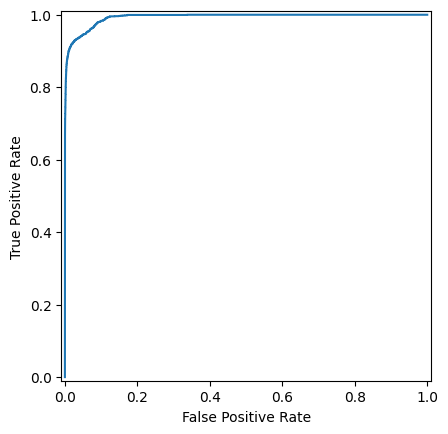

In [51]:
y_score = model.predict_proba(test_features)[:,1]

roc_auc = round(roc_auc_score(test_features_labels["is_laundering"], y_score), 4)
print("roc_auc_score =", roc_auc)
fpr, tpr, _ = roc_curve(test_features_labels["is_laundering"], y_score, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [10]:
%%time

CV_FOLD_PERC = 0.8
N_FOLDS = 5

f1_scores = []
for fold in range(N_FOLDS):
    print("Fold", fold + 1)
    x_train = train_features.sample(frac=CV_FOLD_PERC)
    x_train_labels = x_train.loc[:, []].join(train_features_labels, how="left")
    x_validation = validation_features.sample(frac=CV_FOLD_PERC)
    x_validation_labels = x_validation.loc[:, []].join(validation_features_labels, how="left")
    model_fold = train_model(
        x_train, x_train_labels["is_laundering"].values, 
        x_validation, x_validation_labels["is_laundering"].values,
        cv=True
    )
    y_test_predicted = model_fold.predict(test_features)
    f1_cv = f1_score(test_features_labels["is_laundering"], y_test_predicted) * 100
    print(
        round(f1_cv, 2),
        round(recall_score(test_features_labels["is_laundering"], y_test_predicted) * 100, 2)
    )
    f1_scores.append(f1_cv)

Fold 1
Best iteration: 23

75.85 65.55
Fold 2
Best iteration: 19

76.61 66.72
Fold 3
Best iteration: 24

73.8 62.72
Fold 4
Best iteration: 22

75.31 64.66
Fold 5
Best iteration: 24

76.16 66.39
CPU times: user 4h 23min 41s, sys: 3min 28s, total: 4h 27min 10s
Wall time: 32min 29s


In [13]:
round(np.std(f1_scores), 2)

np.float64(0.97)

In [53]:
gfp_best = 64.77
gfp_std = 0.47

In [54]:
print(f"GFP best: {gfp_best} ± {gfp_std}")

GFP best: 64.77 ± 0.47


In [55]:
print(f"{round(f1_final, 2)} ±{round(np.std(f1_scores), 2)}")

73.34 ±2.03


In [64]:
uplift = round(((f1_final - gfp_best) / gfp_best) * 100, 2)
print(f"Uplift of {uplift}%")

Uplift of 18.2%
